In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from time import sleep

pd.set_option('display.float_format', lambda x: '%.3f' % x)

sns.set()

In [2]:
def construir_linea(sorteo, fecha, tiposorteo, winner, nuevo,n1,n2,n3,n4,n5, sb):
    salida = str(sorteo) + "," + str(fecha) + "," + str(tiposorteo) + "," + str(winner) + "," + str(nuevo) + "," + str(n1) + "," + str(n2) + "," + str(n3) + "," + str(n4) + "," + str(n5) + "," + str(sb)
    return salida

In [3]:
sorteo = int(input("Dígame el numero del sorteo: "))
if(sorteo > 0 ):
    fecha = input(f"ingresa la fecha del sorteo en formato dd/MM/aaaa: {sorteo}: ")
    winner = input(f"ingresa en mayuscula SI o NO, si el sorteo {sorteo} entrego premio mayor o no: ")
    nuevo = input(f"ingresa en mayuscula SI o NO, si el sorteo {sorteo} es nuevo formato o no: ")
    

Dígame el numero del sorteo:  0


In [4]:
if(sorteo > 0 ):
    tiposorteo = input(f"ingresa el tipo de sorteo del sorteo {sorteo}: ")
    n1 = input(f"ingresa el primer numero del sorteo {sorteo}, si en menor a 10 antecede el 0: ")
    n2 = input(f"ingresa el segundo numero del sorteo {sorteo}, si en menor a 10 antecede el 0: ")
    n3 = input(f"ingresa el tercer numero del sorteo {sorteo}, si en menor a 10 antecede el 0: ")
    n4 = input(f"ingresa el cuarto numero del sorteo {sorteo}, si en menor a 10 antecede el 0: ")    
    n5 = input(f"ingresa el quinto numero del sorteo {sorteo}, si en menor a 10 antecede el 0: ")
    sb = input(f"ingresa la superbalota del sorteo {sorteo}, si en menor a 10 antecede el 0: ")
    agregar_a_file = construir_linea(sorteo, fecha, tiposorteo, winner, nuevo,n1,n2,n3,n4,n5, sb)
    print(agregar_a_file)

#### Cargamos el dataset  que tiene el siguiente formato
#### idSorteo,fecha,tipo,ganador,nuevo,n1,n2,n3,n4,n5,sb
#### 1975,21/03/2020,Re,NO,SI,09,22,25,31,40,15
#### 1975,21/03/2020,Tr,NO,SI,04,09,20,35,43,05

In [5]:
def generaPath(tipo, nombre):
    prepath = str(os.getcwd())
    if (tipo == "I"):
        path = prepath + '\\origen\\' + nombre
    else :
        path = prepath + '\\generados\\' + nombre
    return path

In [6]:
df = pd.read_csv(generaPath('I', 'expdata2.csv'), parse_dates=['fecha'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 11 columns):
idSorteo    896 non-null int64
fecha       896 non-null datetime64[ns]
tipo        896 non-null object
ganador     896 non-null object
nuevo       896 non-null object
n1          896 non-null int64
n2          896 non-null int64
n3          896 non-null int64
n4          896 non-null int64
n5          896 non-null int64
sb          896 non-null int64
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 77.1+ KB


In [8]:
conteo_agrupados = df.groupby(['n1', 'n2','n3', 'n4','n5', 'sb']).size()
conteo_agrupados[conteo_agrupados > 1].sort_values(ascending=False).head(10)

Series([], dtype: int64)

#### Definimos el contenido del diccionario que se encarga de interpretar los intervalos de los numeros

In [9]:
deltas = {
     0 : "=",  1 : "A",  2 : "B",  3 : "C",  4 : "D",  5 : "E",  6 : "F",  7 : "G",  8 : "H",  9 : "I", 10 : "J", 11 : "K", 12 : "L", 13 : "M", 14 : "N", 15 : "Ñ", 16 : "O", 17 : "P", 18 : "Q", 
    19 : "R", 20 : "S", 21 : "T", 22 : "U", 23 : "V", 24 : "W", 25 : "X", 26 : "Y", 27 : "Z", 28 : "@", 29 : "a", 30 : "b", 31 : "c", 32 : "d", 33 : "e", 34 : "f", 35 : "g", 36 : "h", 37 : "i", 
    38 : "j", 39 : "k", 40 : "l", 41 : "m", 42 : "n", 43 : "ñ", 44 : "o", 45 : "p", 46 : "q", 47 : "r", 48 : "s", 49 : "t", 50 : "u", 51 : "v", 52 : "w", 53 : "x", 54 : "y", 55 : "z" 
}

#### Creamos nuevo diccionario de pesos por los diferentes analisis

In [10]:
pesos = {
    0 : "0.0", 1 : "0.1", 2 : "0.2", 3: "0.3", 4 : "0.4", 5 : "0.5", 6 : "0.6", 7 : "0.7", 8 : "0.8", 9 : "0.9"     
}

#### Aquí se asignó el valor correspondiente en el diccionario a la diferencia entre los numeros de cada sorteo

In [11]:
def delta_translator(numero1, numero2, suma):
    if (suma > 0):
        return deltas[(suma - numero1) + numero2]
    else:
        #print("num2: ", numero2, " num1 ", numero1)
        return deltas[numero2 - numero1]

In [12]:
delta_translator(4,9,0)

'E'

#### Se encarga de construir una lista con las diferencias numericas para la diferencia entre el ultimo y el primer numero se usa la resta contra el mayor numero permitido al 1 de mayo de 2020 =>> 43

In [13]:
def word_maker(ent1, ent2, ent3, ent4, ent5):
    valDefec = 0
    maxValBal = 43
    listik = []
    listik.append(delta_translator(ent1, ent2, valDefec))
    listik.append(delta_translator(ent2, ent3, valDefec))
    listik.append(delta_translator(ent3, ent4, valDefec))
    listik.append(delta_translator(ent4, ent5, valDefec))
    listik.append(delta_translator(ent5, ent1, maxValBal))
    palabra = "".join(listik)
    return palabra

In [14]:
#print(word_maker(1, 8,17,41,43))

In [15]:
#df.describe()

#### Este es el dataframe sin filtrar

In [16]:
df.head(10)

,idSorteo,fecha,tipo,ganador,nuevo,n1,n2,n3,n4,n5,sb
0,2118,2021-08-09,Re,NO,SI,11,19,28,32,36,6
1,2118,2021-08-09,Tr,NO,SI,8,14,25,31,34,6
2,2117,2021-04-09,Re,NO,SI,8,15,30,36,41,14
3,2117,2021-04-09,Tr,NO,SI,22,30,31,34,41,16
4,2116,2021-01-09,Re,NO,SI,7,12,20,23,32,1
5,2116,2021-01-09,Tr,NO,SI,1,7,9,31,40,13
6,2115,2021-08-28,Re,NO,SI,3,20,27,40,43,1
7,2115,2021-08-28,Tr,NO,SI,8,18,21,30,43,5
8,2114,2021-08-25,Re,NO,SI,3,7,9,17,39,8
9,2114,2021-08-25,Tr,NO,SI,7,18,20,22,34,11


#### Aqui se crean los dataframes filtrados

In [17]:
propiedades = ["Tr"]
df_tr = df[df.tipo.isin(propiedades)]
propiedades = ["Re"]
df_re = df[df.tipo.isin(propiedades)]
#print(df_tr)

#### Aqui se partirian los dataframe en segmentos de entrenamiento y de testeo, a mayor frecuencia mayor peso se puede validar en conjunto para apuntarle a un sorteo con mayor cantidad de veces de ocurrencia

#### En este punto se filtran los sorteos para que solo sean sorteos de los nuevos puesto que la superbalota esta entre 1 y 16

In [18]:
sbs = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]
df_sb_tr = df_tr[df_tr.sb.isin(sbs)]
df_sb_re = df_re[df_re.sb.isin(sbs)]
#print(df_sb_tr)

#### En este punto hago analisis frecuentista de la superbalota (NM Se debe hacer analisis frecuentista de los numeros de manera individual)

In [19]:
dict_sb_tr = dict(df_tr.sb.value_counts())
print(dict_sb_tr)

{11: 43, 13: 37, 7: 36, 2: 36, 16: 32, 3: 31, 5: 28, 4: 28, 8: 26, 10: 24, 14: 23, 6: 23, 12: 22, 1: 22, 9: 21, 15: 16}


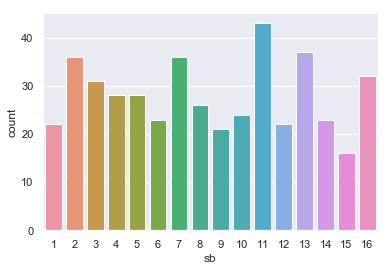

In [20]:
sns.set(style="darkgrid")
ax = sns.countplot(x="sb", data=df_sb_tr)

In [21]:
dict_sb_re = dict(df_re.sb.value_counts())
print(dict_sb_re)

{12: 35, 10: 34, 1: 33, 3: 32, 15: 31, 14: 29, 9: 29, 13: 28, 7: 28, 8: 27, 4: 27, 11: 24, 6: 24, 5: 24, 16: 22, 2: 21}


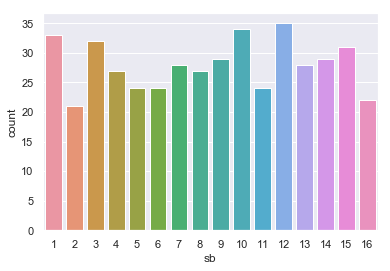

In [22]:
sns.set(style="darkgrid")
ax = sns.countplot(x="sb", data=df_sb_re)

In [23]:
dict_sb = dict(df.sb.value_counts())
print(dict_sb)

{11: 67, 13: 65, 7: 64, 3: 63, 10: 58, 12: 57, 2: 57, 4: 55, 1: 55, 16: 54, 8: 53, 14: 52, 5: 52, 9: 50, 15: 47, 6: 47}


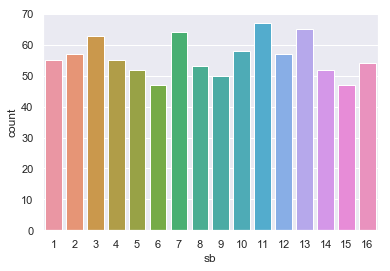

In [24]:
sns.set(style="darkgrid")
ax = sns.countplot(x="sb", data=df)

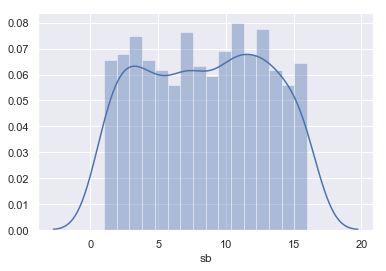

In [25]:
sns.set(style="darkgrid")
x= df.sb
ax = sns.distplot(x, bins=16)

In [26]:
#df.head()
categorical_cols = ['tipo','ganador']
unuseful_cols = ['fecha', 'nuevo']
le = LabelEncoder()

for item in categorical_cols[:]:
    if item == 'tipo' or item == 'ganador':
        nombre_col = str(item) + str('Tr')
        df_tr[nombre_col]= le.fit_transform(df_tr[item])
        nombre_col = str(item) + str('Re')
        df_re[nombre_col]= le.fit_transform(df_re[item])
#print(df_tr)
#print(df_re)


#df_tr = df_object.loc[:, (df.isin({"Tr"})).all(axis=0)]

C:\Users\Ricardo\.conda\envs\dsbasic\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Ricardo\.conda\envs\dsbasic\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [27]:
df_tr_fusion = []
df_re_fusion = []
#print(df_tr)
df_tr_fusion = df_tr.drop(unuseful_cols, axis=1)
df_re_fusion = df_re.drop(unuseful_cols, axis=1)
#print(df_tr_fusion)
df_tr_fu_filt = df_tr_fusion.iloc[:, [0,3,4,5,6,7,8]]
df_re_fu_filt = df_re_fusion.iloc[:, [0,3,4,5,6,7,8]]
Y_tr = df_tr_fusion.iloc[:, 10]
Y_re = df_re_fusion.iloc[:, 10]
filas = int(df_sb_tr.shape[0])
#print(df_tr_fu_filt)
#print(df_re_fu_filt)

In [28]:
def addcolumn(df):
    delta=[]
    for index, row in df.iterrows():
        delta.append(word_maker(row.n1, row.n2, row.n3, row.n4, row.n5))
    df['delta'] = delta
    return df

In [29]:
sorteos = df_tr_fu_filt.shape
print (df_tr_fu_filt)
print(range(sorteos[0]))

     idSorteo  n1  n2  n3  n4  n5  sb
1        2118   8  14  25  31  34   6
3        2117  22  30  31  34  41  16
5        2116   1   7   9  31  40  13
7        2115   8  18  21  30  43   5
9        2114   7  18  20  22  34  11
..        ...  ..  ..  ..  ..  ..  ..
886      1675   1  20  36  39  43  10
888      1674   5   6   7  12  37   6
890      1673   6  19  25  28  36   1
892      1672   1   2  25  31  33  14
894      1671  15  28  36  37  41  10

[448 rows x 7 columns]
range(0, 448)


In [30]:
df_tr_fu_filt_1 = df_tr_fu_filt[(df_tr_fu_filt['n1']==1) & (df_tr_fu_filt['n2']==2)]
df_tr_fu_filt_2 = df_tr_fu_filt_1[df_tr_fu_filt_1['n2']==3]
#df_tr_fu_filt_1 = df_tr_fu_filt.filter(='10', axis=0)
sorteos2 = df_tr_fu_filt_1.shape
print (df_tr_fu_filt_1)

print(range(sorteos2[0]))

     idSorteo  n1  n2  n3  n4  n5  sb
179      2029   1   2   5  16  23  11
191      2023   1   2  15  36  39   4
436      1900   1   2   3  10  31   1
456      1890   1   2  22  29  42  16
746      1745   1   2   4   5  13  10
748      1744   1   2  33  34  41  10
814      1711   1   2  20  31  43   8
892      1672   1   2  25  31  33  14
range(0, 8)


#### Se definen los archivos a los que se exportaran los dataframes que incluyen los deltas Calculados  

In [31]:
df_tr_fu_filt = addcolumn(df_tr_fu_filt)
df_tr_fu_filt.to_csv(generaPath('O', 'df_tr_fu_filt_delta.csv'), header=['idSorteo','n1','n2','n3','n4', 'n5','sb','delta'], index=None, sep=',', mode='w')
print(df_tr_fu_filt)

     idSorteo  n1  n2  n3  n4  n5  sb  delta
1        2118   8  14  25  31  34   6  FKFCP
3        2117  22  30  31  34  41  16  HACGW
5        2116   1   7   9  31  40  13  FBUID
7        2115   8  18  21  30  43   5  JCIMH
9        2114   7  18  20  22  34  11  KBBLO
..        ...  ..  ..  ..  ..  ..  ..    ...
886      1675   1  20  36  39  43  10  ROCDA
888      1674   5   6   7  12  37   6  AAEXK
890      1673   6  19  25  28  36   1  MFCHM
892      1672   1   2  25  31  33  14  AVFBK
894      1671  15  28  36  37  41  10  MHADP

[448 rows x 8 columns]


C:\Users\Ricardo\.conda\envs\dsbasic\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [32]:
print(df_re_fu_filt)
df_re_fu_filt = addcolumn(df_re_fu_filt)
df_re_fu_filt.to_csv(generaPath('O', 'df_re_fu_filt_delta.csv'), header=['idSorteo','n1','n2','n3','n4', 'n5','sb','delta'], index=None, sep=',', mode='w')
print(df_re_fu_filt)

     idSorteo  n1  n2  n3  n4  n5  sb
0        2118  11  19  28  32  36   6
2        2117   8  15  30  36  41  14
4        2116   7  12  20  23  32   1
6        2115   3  20  27  40  43   1
8        2114   3   7   9  17  39   8
..        ...  ..  ..  ..  ..  ..  ..
887      1675   3   5   8  20  24  14
889      1674   5  12  15  20  42  14
891      1673   8  21  22  37  38   4
893      1672   9  12  16  28  38   1
895      1671   3   9  10  21  40  10

[448 rows x 7 columns]
     idSorteo  n1  n2  n3  n4  n5  sb  delta
0        2118  11  19  28  32  36   6  HIDDQ
2        2117   8  15  30  36  41  14  GÑFEJ
4        2116   7  12  20  23  32   1  EHCIQ
6        2115   3  20  27  40  43   1  PGMCC
8        2114   3   7   9  17  39   8  DBHUG
..        ...  ..  ..  ..  ..  ..  ..    ...
887      1675   3   5   8  20  24  14  BCLDU
889      1674   5  12  15  20  42  14  GCEUF
891      1673   8  21  22  37  38   4  MAÑAM
893      1672   9  12  16  28  38   1  CDLJN
895      1671   3   9  10

C:\Users\Ricardo\.conda\envs\dsbasic\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### validar cuantas veces se repiten los deltas, para validar si existe algun patron de repeticion

In [33]:
#sorteo = df_tr_fu_filt[df_tr_fu_filt.idSorteo == '198']
#print(sorteo)
#df_tr_fu_filt.loc['n1'].tolist()
#idSorteo = '1975'
#values = df_tr_fu_filt.loc[idSorteo].tolist()
#print(values)


#### Se hacen los conteos de  los deltas y sus ocurrencias (NM Con este listado se debe validar expresiones similares para determinar comportamiento y posibles semejanzas entre ellos Ej MCACV similar a MCBCV, debe validarse que porcion de una expresion esta en la otras, a futuro deberia validarse la correlacion entre sorteo TR y sorteo RE )

In [34]:
df_tr_fu_filt.delta.value_counts()

MCACV    2
ASGMB    1
KCIDO    1
SEACN    1
EGKFN    1
        ..
AAAWO    1
SHDEF    1
BFAJW    1
FDANQ    1
LEFEÑ    1
Name: delta, Length: 447, dtype: int64

In [35]:
df_re_fu_filt.delta.value_counts()

MKDAN    2
GARBN    1
JCSDF    1
MAFKL    1
GFFHO    1
        ..
GDUDF    1
KCFBT    1
CHKAS    1
BFMCR    1
OJBAN    1
Name: delta, Length: 447, dtype: int64

In [36]:
#def transforma_unos(df_tr_fu_filt)
#    for i in range(0, df_tr_fu_filt.shape[1])
        


#### Los numeros de las columnas n1-n5 seran fusionadas, seran transformados a una sola dimension, para poder determinar la frecuencia con la que acontecen, en primera instancia seran separados por tipo de sorteo, y en el nuevo dataset tendremos el numero del sorteo y el numero

In [37]:
#print(Y_tr)
#print(Y_re)
main_columns = ['n1','n2','n3', 'n4', 'n5', 'sb','tipo', 'ganador']

#### Este contenido se usa para segmentar el dataframe en los siguientes contextos single, duplas, ternas cuartetos y quintetos con y sin superbalota

In [38]:
df

,idSorteo,fecha,tipo,ganador,nuevo,n1,n2,n3,n4,n5,sb
0,2118,2021-08-09,Re,NO,SI,11,19,28,32,36,6
1,2118,2021-08-09,Tr,NO,SI,8,14,25,31,34,6
2,2117,2021-04-09,Re,NO,SI,8,15,30,36,41,14
3,2117,2021-04-09,Tr,NO,SI,22,30,31,34,41,16
4,2116,2021-01-09,Re,NO,SI,7,12,20,23,32,1
...,...,...,...,...,...,...,...,...,...,...,...
891,1673,2017-04-29,Re,NO,SI,8,21,22,37,38,4
892,1672,2017-04-26,Tr,NO,SI,1,2,25,31,33,14
893,1672,2017-04-26,Re,NO,SI,9,12,16,28,38,1
894,1671,2017-04-22,Tr,NO,SI,15,28,36,37,41,10


In [39]:
def cortasbs(df, sb):
    df_filt = df.iloc[0::1,[0, 6]]
    print (df_filt)
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [40]:
def cortasingles(df, col0, col1):
    df_filt = df.iloc[0::1,[col0, col1]]
    print (df_filt)
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [41]:
def cortasinglessb(df, col0, col1, sb):
    df_filt = df.iloc[0::1,[col0, col1, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [42]:
def cortaduplas(df, col0, col1, col2):
    df_filt = df.iloc[0::1,[col0, col1, col2]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [43]:
def cortaduplassb(df, col0, col1, col2, sb):
    df_filt = df.iloc[0::1,[col0, col1, col2, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [44]:
def cortatrios(df, col0, col1, col2, col3):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [45]:
def cortatriossb(df, col0, col1, col2, col3, sb):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [46]:
def cortacuartetos(df, col0, col1, col2, col3, col4):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, col4]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [47]:
def cortacuartetossb(df, col0, col1, col2, col3, col4, sb):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, col4, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [48]:
def cortaquintetos(df, col0, col1, col2, col3, col4, col5):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, col4, col5]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [49]:
def cortaquintetossb(df, col0, col1, col2, col3, col4, col5, sb):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, col4, col5, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

#### El siguiente contenido se usa para fusionar los dataframes desde los diferentes enfoques, singles, duplas, trios, etc

In [50]:
def concatenador_sbs(df, sb):
    colid = 0
    df_1d_sb_tr = cortasbs(df, sb) # if sb > 0 else cortasingles(df,colid,1)
    df_1d_sb_tr.columns = ['idSorteo', 'sb'] # if sb > 0 else ['idSorteo', 'num1']
    print("final: ",df_1d_sb_tr)
    return df_1d_sb_tr

In [51]:
def concatenador_singles(df, sb):
    colid = 0
    df_1d_fu_tr = cortasinglessb(df,colid,1, sb) if sb > 0 else cortasingles(df,colid,1)
    print (df_1d_fu_tr)
    inicial = 0
    for i in range(1,6):
        df_temp_fusion = cortasinglessb(df, colid, i, sb) if sb > 0 else cortasingles(df, colid, i)
        if (inicial == 0):
            df_1d_fu_tr = df_temp_fusion
            inicial += 1
        else :
            df_1d_fu_tr = pd.concat([df_1d_fu_tr, df_temp_fusion], ignore_index=True)
    df_1d_fu_tr.columns = ['idSorteo', 'num1', 'sb'] if sb > 0 else ['idSorteo', 'num1']
    return df_1d_fu_tr

In [52]:
def concatenador_duplas(df,sb):
    colid = 0
    inicial = 0
    for i in range(1,6):
        for ii in range(i+1, 6):
            df_temp_fusion = cortaduplassb(df, colid, i, ii, sb) if sb > 0 else cortaduplas(df, colid, i, ii)
            if (inicial == 0):
                df_2d_fu_tr = df_temp_fusion
                inicial += 1
            else :
                df_2d_fu_tr = pd.concat([df_2d_fu_tr, df_temp_fusion], ignore_index=True)
    df_2d_fu_tr.columns = ['idSorteo', 'num1', 'num2', 'sb'] if sb > 0 else ['idSorteo', 'num1', 'num2']
    return df_2d_fu_tr

In [53]:
def concatenador_trios(df,sb):
    colid = 0
    df_3d_fu_tr = cortatriossb(df, colid, 1, 2, 3, sb) if sb > 0 else cortatrios(df, colid, 1, 2, 3)
    inicial = 0
    for i in range(1,6):
        for ii in range(i + 1, 6):
            for iii in range(ii + 1, 6):
                df_temp_fusion = cortatriossb(df, colid, i, ii, iii, sb) if sb > 0 else cortatrios(df, colid, i, ii, iii)
                if (inicial == 0):
                    df_3d_fu_tr = df_temp_fusion
                    inicial += 1
                else :
                    df_3d_fu_tr = pd.concat([df_3d_fu_tr, df_temp_fusion], ignore_index=True)
    df_3d_fu_tr.columns = ['idSorteo', 'num1', 'num2', 'num3', 'sb'] if sb > 0 else ['idSorteo', 'num1', 'num2', 'num3']
    return df_3d_fu_tr

In [54]:
def concatenador_cuartetos(df, sb):
    colid = 0
    inicial = 0
    for i in range(1,6):
        for ii in range(i + 1, 6):
            for iii in range(ii + 1, 6 ):
                for iiii in range(iii + 1, 6 ):
                    df_temp_fusion = cortacuartetossb(df, colid, i, ii, iii, iiii, sb) if sb > 0 else cortacuartetos(df, colid, i, ii, iii, iiii)
                    if (inicial == 0):
                        df_4d_fu_tr = df_temp_fusion
                        inicial += 1
                    else :
                        df_4d_fu_tr = pd.concat([df_4d_fu_tr, df_temp_fusion], ignore_index=True)
    df_4d_fu_tr.columns = ['idSorteo', 'num1', 'num2', 'num3', 'num4', 'sb'] if sb > 0 else ['idSorteo', 'num1', 'num2', 'num3', 'num4']
    return df_4d_fu_tr

In [55]:
def concatenador_quintetos(df, sb):
    colid = 0
    df_5d_fu_tr = cortaquintetossb(df, colid, 1, 2, 3, 4, 5, sb) if sb > 0 else  cortaquintetos(df, colid, 1, 2, 3, 4, 5)
    df_5d_fu_tr.columns = ['idSorteo', 'num1', 'num2', 'num3', 'num4', 'num5', 'sb'] if sb > 0 else ['idSorteo', 'num1', 'num2', 'num3', 'num4', 'num5']
    return df_5d_fu_tr

In [56]:
def tuple_maker(ent1, ent2, ent3, ent4, ent5, cant):
    listik = []
    if (cant >= 1):
        listik.append(str(ent1))
    if (cant >= 2):       
        listik.append("|" + str(ent2))
    if (cant >= 3):
        listik.append("|" + str(ent3))
    if (cant >= 4):
        listik.append("|" + str(ent4))
    if (cant >= 5):
        listik.append("|" + str(ent5))
    palabra = "".join(listik)
    return palabra

#### Con la siguiente funcion adicionamos una nueva columna 'la de las tuplas'

In [57]:
def addcolumntuplas(df, cant):
    tupla=[]
    val_defecto = 0
    df.to_frame()
    df2 = df.rename(None).to_frame().T
    for index, row in df2.iteritems():
        if (cant == 1): 
            tupla.append(tuple_maker(index, val_defecto, val_defecto, val_defecto, val_defecto, cant)) 
        if (cant == 2):
            tupla.append(tuple_maker(index[0], index[1], val_defecto, val_defecto, val_defecto, cant))
        if (cant == 3): 
            tupla.append(tuple_maker(index[0], index[1], index[2], val_defecto, val_defecto, cant))  
        if (cant == 4): 
            tupla.append(tuple_maker(index[0], index[1], index[2], index[3], val_defecto, cant))  
        if (cant == 5): 
            tupla.append(tuple_maker(index[0], index[1], index[2], index[3], index[4], cant))  
    dft = df2.T
    dft['tupla'] = tupla
    dft = dft.reset_index(drop=True)
    return dft

#### Se definen los metodos para agrupar el contenido del dataframe en grupos de acuerdo a cantidad de numeros involucrados

In [58]:
def agrupa_sbs(df):
    conteo_nums = df.groupby(['sb']).size()
    tupla  = []
    df = addcolumntuplas(conteo_nums, 1)
    df.columns = ['conteo','tupla']
    return df

In [59]:
def agrupa_singles(df):
    conteo_nums = df.groupby(['num1']).size()
    tupla  = []
    df = addcolumntuplas(conteo_nums, 1)
    df.columns = ['conteo','tupla']
    return df

In [60]:
def agrupa_duplas(df):
    conteo_nums = df.groupby(['num1', 'num2']).size()
    tupla  = []
    df = addcolumntuplas(conteo_nums, 2)
    df.columns = ['conteo','tupla']
    return df

In [61]:
def agrupa_trios(df):
    conteo_nums = df.groupby(['num1', 'num2', 'num3']).size()
    tupla  = []
    df = addcolumntuplas(conteo_nums, 3)
    df.columns = ['conteo','tupla']
    return df

In [62]:
def agrupa_cuartetos(df):
    conteo_nums = df.groupby(['num1', 'num2', 'num3', 'num4']).size()
    tupla  = []
    df = addcolumntuplas(conteo_nums, 4)
    df.columns = ['conteo','tupla']
    return df

In [63]:
def agrupa_quintetos(df):
    conteo_nums = df.groupby(['num1', 'num2', 'num3', 'num4', 'num5']).size()
    tupla  = []
    df = addcolumntuplas(conteo_nums, 5)
    df.columns = ['conteo','tupla']
    return df

#### Aquí se hace la separacion a un dataframe de solo 1 numero

In [64]:
df_1d_sb_tr = concatenador_sbs(df_tr_fu_filt, 0)
conteos_1d_sb_tr = agrupa_sbs(df_1d_sb_tr)
conteos_1d_sb_tr.to_csv(generaPath('O', 'conteos_1d_sb_tr.csv'), header=['conteo','tupla'], index=None, sep=',', mode='w') 

     idSorteo  sb
1        2118   6
3        2117  16
5        2116  13
7        2115   5
9        2114  11
..        ...  ..
886      1675  10
888      1674   6
890      1673   1
892      1672  14
894      1671  10

[448 rows x 2 columns]
final:       idSorteo  sb
1        2118   6
3        2117  16
5        2116  13
7        2115   5
9        2114  11
..        ...  ..
886      1675  10
888      1674   6
890      1673   1
892      1672  14
894      1671  10

[448 rows x 2 columns]


In [65]:
df_1d_sb_re = concatenador_sbs(df_re_fu_filt, 0)
conteos_1d_sb_re = agrupa_sbs(df_1d_sb_re)
conteos_1d_sb_re.to_csv(generaPath('O', 'conteos_1d_sb_re.csv'), header=['conteo','tupla'], index=None, sep=',', mode='w') 

     idSorteo  sb
0        2118   6
2        2117  14
4        2116   1
6        2115   1
8        2114   8
..        ...  ..
887      1675  14
889      1674  14
891      1673   4
893      1672   1
895      1671  10

[448 rows x 2 columns]
final:       idSorteo  sb
0        2118   6
2        2117  14
4        2116   1
6        2115   1
8        2114   8
..        ...  ..
887      1675  14
889      1674  14
891      1673   4
893      1672   1
895      1671  10

[448 rows x 2 columns]


In [66]:
df_1d_fusion_tr = concatenador_singles(df_tr_fu_filt, 0)
conteos_1d_tr = agrupa_singles(df_1d_fusion_tr)
conteos_1d_tr.to_csv(generaPath('O', 'conteos_1d_tr.csv'), header=['conteo','tupla'], index=None, sep=',', mode='w')

     idSorteo  n1
1        2118   8
3        2117  22
5        2116   1
7        2115   8
9        2114   7
..        ...  ..
886      1675   1
888      1674   5
890      1673   6
892      1672   1
894      1671  15

[448 rows x 2 columns]
     idSorteo  num
1        2118    8
3        2117   22
5        2116    1
7        2115    8
9        2114    7
..        ...  ...
886      1675    1
888      1674    5
890      1673    6
892      1672    1
894      1671   15

[448 rows x 2 columns]
     idSorteo  n1
1        2118   8
3        2117  22
5        2116   1
7        2115   8
9        2114   7
..        ...  ..
886      1675   1
888      1674   5
890      1673   6
892      1672   1
894      1671  15

[448 rows x 2 columns]
     idSorteo  n2
1        2118  14
3        2117  30
5        2116   7
7        2115  18
9        2114  18
..        ...  ..
886      1675  20
888      1674   6
890      1673  19
892      1672   2
894      1671  28

[448 rows x 2 columns]
     idSorteo  n3
1        2

In [67]:
df_1d_fusion_re = concatenador_singles(df_re_fu_filt, 0)
conteos_1d_re = agrupa_singles(df_1d_fusion_re)
conteos_1d_re.to_csv(generaPath('O', 'conteos_1d_re.csv'), header=['conteo','tupla'], index=None, sep=',', mode='w')

     idSorteo  n1
0        2118  11
2        2117   8
4        2116   7
6        2115   3
8        2114   3
..        ...  ..
887      1675   3
889      1674   5
891      1673   8
893      1672   9
895      1671   3

[448 rows x 2 columns]
     idSorteo  num
0        2118   11
2        2117    8
4        2116    7
6        2115    3
8        2114    3
..        ...  ...
887      1675    3
889      1674    5
891      1673    8
893      1672    9
895      1671    3

[448 rows x 2 columns]
     idSorteo  n1
0        2118  11
2        2117   8
4        2116   7
6        2115   3
8        2114   3
..        ...  ..
887      1675   3
889      1674   5
891      1673   8
893      1672   9
895      1671   3

[448 rows x 2 columns]
     idSorteo  n2
0        2118  19
2        2117  15
4        2116  12
6        2115  20
8        2114   7
..        ...  ..
887      1675   5
889      1674  12
891      1673  21
893      1672  12
895      1671   9

[448 rows x 2 columns]
     idSorteo  n3
0        2

In [68]:
df_2d_fusion_tr = concatenador_duplas(df_tr_fu_filt, 0)
conteos_2d_tr = agrupa_duplas(df_2d_fusion_tr)
conteos_2d_tr.to_csv(generaPath('O', 'conteos_2d_tr.csv'), header=['conteo','tupla'], index=None, sep=',', mode='w')

In [69]:
df_2d_fusion_re = concatenador_duplas(df_re_fu_filt, 0)
conteos_2d_re = agrupa_duplas(df_2d_fusion_re)
conteos_2d_re.to_csv(generaPath('O', 'conteos_2d_re.csv'), header=['conteo','tupla'], index=None, sep=',', mode='w')

In [70]:
df_3d_fusion_tr = concatenador_trios(df_tr_fu_filt, 0)
conteos_3d_tr = agrupa_trios(df_3d_fusion_tr)
conteos_3d_tr.to_csv(generaPath('O', 'conteos_3d_tr.csv'), header=['conteo','tupla'], index=None, sep=',', mode='w')

In [71]:
df_3d_fusion_re = concatenador_trios(df_re_fu_filt, 0)
conteos_3d_re = agrupa_trios(df_3d_fusion_re)
conteos_3d_re.to_csv(generaPath('O', 'conteos_3d_re.csv'), header=['conteo','tupla'], index=None, sep=',', mode='w')

In [72]:
df_4d_fusion_tr = concatenador_cuartetos(df_tr_fu_filt,0)
conteos_4d_tr = agrupa_cuartetos(df_4d_fusion_tr)
conteos_4d_tr.to_csv(generaPath('O', 'conteos_4d_tr.csv'), header=['conteo','tupla'], index=None, sep=',', mode='w')

In [73]:
df_4d_fusion_re = concatenador_cuartetos(df_re_fu_filt,0)
conteos_4d_re = agrupa_cuartetos(df_4d_fusion_re)
conteos_4d_re.to_csv(generaPath('O', 'conteos_4d_re.csv'), header=['conteo','tupla'], index=None, sep=',', mode='w')

In [74]:
df_5d_fusion_tr = concatenador_quintetos(df_tr_fu_filt, 0)
conteos_5d_tr = agrupa_quintetos(df_5d_fusion_tr)
conteos_5d_tr.to_csv(generaPath('O', 'conteos_5d_tr.csv'), header=['conteo','tupla'], index=None, sep=',', mode='w')

In [75]:
df_5d_fusion_re = concatenador_quintetos(df_re_fu_filt, 0)
conteos_5d_re = agrupa_quintetos(df_5d_fusion_re)
conteos_5d_re.to_csv(generaPath('O', 'conteos_5d_re.csv'), header=['conteo','tupla'], index=None, sep=',', mode='w')

In [76]:
df_final = df_3d_fusion_tr

In [77]:
df_final

,idSorteo,num1,num2,num3
0,2118,8,14,25
1,2117,22,30,31
2,2116,1,7,9
3,2115,8,18,21
4,2114,7,18,20
...,...,...,...,...
4475,1675,36,39,43
4476,1674,7,12,37
4477,1673,25,28,36
4478,1672,25,31,33


In [78]:
#sns.set(style="darkgrid")
#ax = sns.countplot(y="num", data=df_final)

In [79]:
#sns.set(style="darkgrid")
#x= df_final.num
#ax = sns.distplot(x, bins=43)

TypeError: can't multiply sequence by non-int of type 'float'

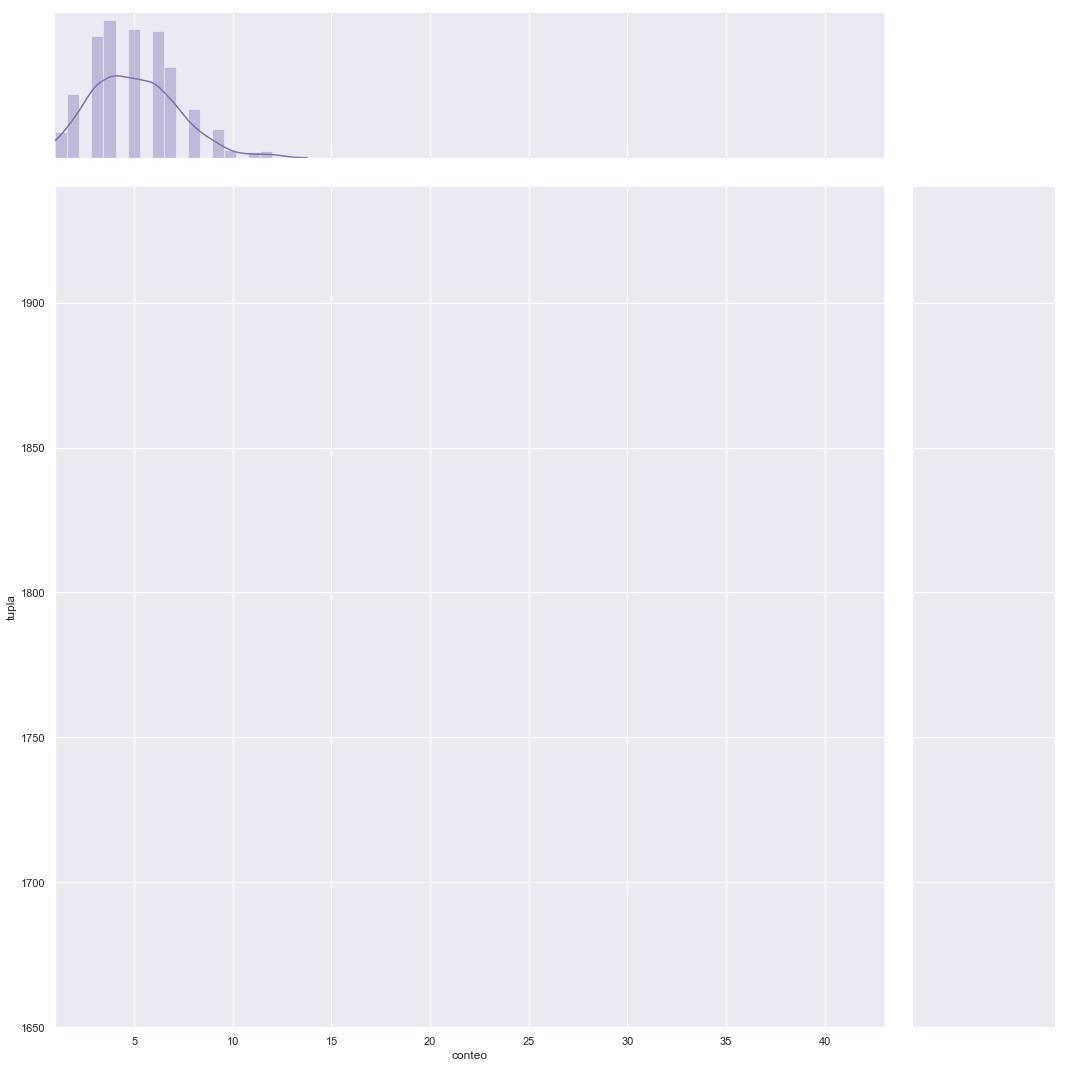

In [80]:
#df_topes = df_tr_fu_filt_delta.iloc[0::1,[0]]
g = sns.jointplot("conteo", "tupla",  data=conteos_2d_re, kind="reg", xlim=(1, 43), ylim=(1650, 1940), color="m", height=15)

In [ ]:
sns.pairplot(df_final, hue="num")

In [ ]:
grid = sns.FacetGrid(df_final, col="num", hue="num", palette="tab20c", col_wrap=4, height=4)
grid.map(plt.axhline, y=0, ls=":", c=".5")
grid.map(plt.plot, "num", "idSorteo", marker="o")
grid.set(xticks=np.arange(5), yticks=[-3, 3], xlim=(-.5, 4.5), ylim=(-3.5, 3.5))
grid.fig.tight_layout(w_pad=1)

In [ ]:
a4_dims = (11.7, 8.27)
df = mylib.load_data()
fig, ax = pyplot.subplots(figsize=a4_dims)
seaborn.violinplot(ax=ax, data=df, **violin_options)

ax = sns.barplot(x="num", y="num", data=df_final, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")

In [ ]:
df_conteos = df_final.num.value_counts()
df_conteos.info()

In [ ]:
sns.set(style="darkgrid")
x= df_conteos.num
ax = sns.distplot(x, bins=43)